<a href="https://colab.research.google.com/github/JakobSchauser/BachelorProject-IceCube-ML/blob/main/Model_with_Thomas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spektral -q

import numpy as np
import tensorflow as tf
import keras
import pickle
import spektral

from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import MeanAbsoluteError as MeanAbsoluteError_acc
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.sparse import SparseTensor

from keras import backend as K



from spektral.data import DisjointLoader, Dataset
from spektral.datasets import QM9
from spektral.layers import AGNNConv, GlobalSumPool, GlobalMaxPool, GlobalAvgPool, GCNConv, ECCConv, CrystalConv

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

PI = np.pi

# Lifehack
true = True
false = False

In [ ]:
!pip install wandb -q

import wandb
from wandb.keras import WandbCallback

wandb.login()

True

In [ ]:
################################################################################
# LOAD DATA
################################################################################
# Find the reverse transformer
pcl = "/content/drive/MyDrive/Bachelor Project - IceCube ML/transformers.pkl"

with open(pcl,'rb') as tra:
    transformer = pickle.load(tra)

transformer = transformer["truth"]


class dat(Dataset):
  def __init__(self,n = 1,**kwargs):
    self.n = n
    super().__init__(**kwargs)
  def read(self):
    # path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/generatedDataAnglesEnergy100000 0.npz" # Uncleaned
    path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/generatedDataAnglesEnergyClean200000events 0.npz" # Cleaned
    # path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/data.dat" # From Severin
    dataset = np.load(path,allow_pickle = True)["arr_0"]
    graphs = []
    for g in dataset:
      # e,a,z = g["y"]
      # g["y"] = [transformer['energy_log10'].transform([[e]])[0][0],transformer['azimuth'].transform([[a]])[0][0],transformer['zenith'].transform([[z]])[0][0]]
      graphs.append(g)
    return np.array(dataset)

dataset = dat()

print("Dataset is", dataset, "consisting of", dataset[0])




#### Put on GPU when possible
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("Running on GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("Running on CPU")

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.19.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Dataset is dat(n_graphs=200000) consisting of Graph(n_nodes=13, n_node_features=5, n_edge_features=None, n_labels=3)
Running on CPU


In [ ]:
from spektral.transforms import GCNFilter

dataset.apply(GCNFilter())

NameError: ignored

In [ ]:
def custom_loss(target,predictions):
    predictions = tf.cast(predictions,"float64")

    energy    = tf.abs(target[:,0] - predictions[0])
    azi       = tf.abs(target[:,1] - predictions[1]) # [:,1] 
    zeni      = tf.abs(target[:,2] - predictions[2])


    # azi  = tf.minimum(azi, tf.abs(tf.abs(azi )-2))     # 2 should be pi or 2pi
    # zeni = tf.minimum(tf.abs(zeni), tf.abs(tf.abs(zeni)-2))  # 2 should be pi or 2pi

    # azi, zeni = azi*10,zeni*10

    #Trying something crazy
    # more = 2
    # menergy, mazi, mzeni = tf.where(energy<tf.abs(predictions[:,0]-mean_energy),energy,energy*more), tf.where(azi<tf.abs(predictions[:,1]-mean_azimuth),azi,azi*more), tf.where(zeni<tf.abs(predictions[:,2]-mean_zenith),zeni,zeni*more)
    # energy,azi,zeni = menergy,mazi,mzeni


    loss = 0
    loss += tf.reduce_mean(tf.square(energy))
    loss += tf.reduce_mean(tf.square(azi))
    loss += tf.reduce_mean(tf.square(zeni))
    return loss

loss_fn = custom_loss

def custom

def scale_inputs(inputs):
    inputs[0][:,:3] = inputs[0][:,:3]/100 # x y z
    inputs[0][:,3] = inputs[0][:,3]/10000 # time
    inputs[0][:,4] = inputs[0][:,4]/1 # charge
    return inputs




In [ ]:
################################################################################
# PARAMETERS
################################################################################
#@markdown ### Define the model and training parameters and sync with WandB
batch_size =  64#@param {type: "number"}

# one-variable network size changer
network_size =  128#@param {type: "number"}

learning_rate = 1e-4  #@param {type: "number"}

training_epochs = 50 #@param {type: "number"}


loss_function = "custom_loss"  #@param ['custom_loss']

config = {
        "learning_rate": learning_rate,
        "epochs": training_epochs,
        "batch_size": batch_size,
        "loss_function": loss_function,
        "architecture": "Thomas - short but wide",
        "network_size": network_size,
        "dataset": "MuonGun"
      }

epochs = config["epochs"]  # Number of training epochs
test_epochs = 2 # Number of testing epochs



In [ ]:
# Parameters
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
n_out = dataset.n_labels  # Dimension of the target

# Train/test split
idxs = np.random.permutation(len(dataset))
split = int(0.9 * len(dataset))
idx_tr, idx_te = np.split(idxs, [split])
dataset_tr, dataset_te = dataset[idx_tr], dataset[idx_te]

train_loader = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs, shuffle=True)
test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=test_epochs, shuffle=True)


def skrrt(x):
  return tf.minimum(tf.maximum(-10,x),10)/10


from keras.utils.generic_utils import get_custom_objects

get_custom_objects().update({'skrrt_activation': Activation(skrrt)})


class model_class(Model):
  def __init__(self):
    super().__init__()
    

    # self.inp = ECCConv(network_size//4,activation="relu")
    self.conv = GCNConv(network_size//4,activation="relu")

    self.maxpool = GlobalMaxPool()
    self.avgpool = GlobalAvgPool()
    self.sumpool = GlobalSumPool()

    self.largedense= Dense(network_size,activation="gelu")
    self.mediumdense= Dense(network_size//2,activation="gelu")
                           
    self.smalldense = Dense(network_size//4)

    self.out = Dense(1,activation=Activation("skrrt_activation"))
 

  def call(self, inputs, training = False):
    x, a, i = inputs
    # a, e    = self.generate_edge_features(x, a) # NEXT STEP is implementing this

    # We really should be using dropout = 0.2

    # x = self.inp([x,a,e])
    x = self.conv([x,a])
    x = self.conv([x,a])


    xm = self.maxpool([x,i])
    xa = self.avgpool([x,i])
    xs = self.sumpool([x,i])

    x = tf.concat([xm, xa, xs], axis = 1) 

    x = self.largedense(x)
    x = self.mediumdense(x)

    xe = self.smalldense(x)
    xa = self.smalldense(x)
    xz = self.smalldense(x)

    # Potentially another layer here

    oute = self.out(xe)
    outa = self.out(xa)
    outz = self.out(xz)
    # x = tf.concat([xa, x2, x3], axis = 1)

    return oute,outa,outz
    # return oute,outa,outz

  #Shamelessly stolen from Johann
  def generate_edge_features(self, x, a):
      send    = a.indices[:, 0]
      receive = a.indices[:, 1]

      diff_x  = tf.subtract(tf.gather(x, receive), tf.gather(x, send))

      dists   = tf.sqrt(
        tf.reduce_sum(
          tf.square(
            diff_x[:, :3]
          ), axis = 1
        ))

      vects = tf.math.divide_no_nan(diff_x[:, :3], tf.expand_dims(dists, axis = -1))

      e = tf.concat([diff_x[:, 3:], tf.expand_dims(dists, -1), vects], axis = 1)

      return a, e

# Build model
model = model_class()

opt = Adam(lr=learning_rate)
loss_fn = custom_loss
# loss_fn = MeanAbsoluteError()
acc_fn = MeanAbsoluteError()


model.compile()
# model.build()

NameError: ignored

In [ ]:
################################################################################
# DEFINE TF-FUNCTIONS
################################################################################
@tf.function(input_signature=train_loader.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions)
        loss += sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    acc = acc_fn(target,predictions)

    return loss, acc

def validate(inputs,target):
    predictions = model(inputs, training=False)
    loss = loss_fn(target, predictions)
    loss += sum(model.losses)
    acc = acc_fn(target,predictions)

    return loss, acc




loss_fn = custom_loss

def fit(train_loader):
  # run = wandb.init(project='IceCube GNN Bachelor',config = config)
  current_batch = 0
  model_loss = []
  model_acc = []
  vali_acc = []
  epoch = 0

  epoch_steps = train_loader.steps_per_epoch

  t = tqdm(total  = train_loader.steps_per_epoch,leave = True)
  t.set_description(f'Currently on epoch {0} of {epochs} ')


  guesses, truths = [],[]
  # fig, axs = plt.subplots(1,2,figsize=(14,6))
  # axs[0].set(title="Zenith")
  # axs[0].hist(np.random.rand(100),bins=50,histtype="step")
  plt.show()
  pb = []
  tar = []
  step = 0

  last_loss = 0
  for batch in train_loader:
      step += 1
      inputs, target = batch
      inputs = scale_inputs(inputs)

      
      guesses.append(model(inputs,training=False))
      truths.append(target)

      loss, acc = train_step(inputs,target)

      model_loss.append(loss)
      model_acc.append(acc)
      current_batch += 1
      t.update(1)
      if current_batch == epoch_steps:
          pg,pt = np.array(guesses[-1]), np.array(truths[-1])

          # print(pg,pt)
          fig, axs = plt.subplots(1,3,figsize=(14,6))
          for kkk in range(3):
            axs[kkk].hist(np.array(pg[kkk]),bins = 50,histtype="step")
            axs[kkk].hist(np.array(pt[:,kkk]),bins=50,histtype="step")
          plt.show()
          guesses, truths = [],[]


          test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=test_epochs, shuffle=True)
          t.set_description(f'Currently validating results')

          for vali_batch in test_loader:
            vali_inputs, vali_target = vali_batch
            valie_inputs = scale_inputs(vali_inputs)
            vali_loss, va = validate(vali_inputs,vali_target)
            vali_acc.append(va)
          va = np.mean(vali_acc)

          m_loss = np.mean(model_loss)
          change = (m_loss-last_loss)/max(0.000001,last_loss)
          last_loss = m_loss

          s = "Train loss: {} - Train accuracy: {} - Loss change {:+.3f}% | Validation accuracy {} | Epoch: {}".format(m_loss, np.mean(model_acc), change*100,va, epoch)
          t.write(s)
          if epoch%5 == 0 and epoch != 0:
            # print("Two current guesses are\n",np.array(pg[0]),np.array(pg[1]),"for\n",pt[0],pt[1])
            pass




          # wandb.log({
          #           "train_loss": m_loss,
          #           "train_accuracy": np.mean(model_acc),
          #           "val_loss": va,
          #           })




          model_loss = []
          model_acc = []
          vali_acc = []
          current_batch = 0
          step = 0

          t.n = 0
          t.last_print_n = 0
          t.refresh()
          epoch += 1

          t.set_description(f'Currently on epoch {epoch} of {epochs} ')


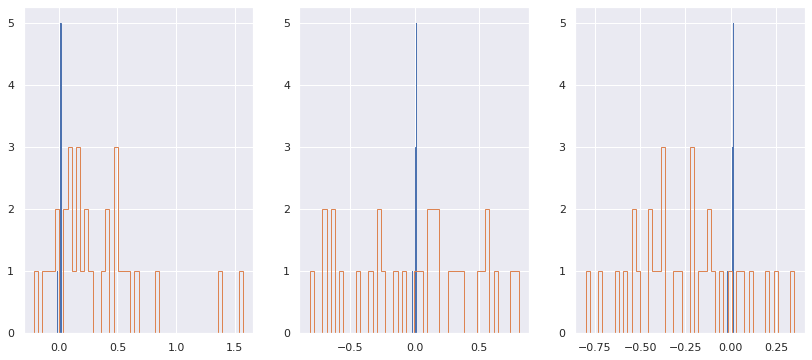

Train loss: 0.6757321173240454 - Train accuracy: 0.39102718234062195 - Loss change +67573211.732% | Validation accuracy 0.3901696801185608 | Epoch: 0


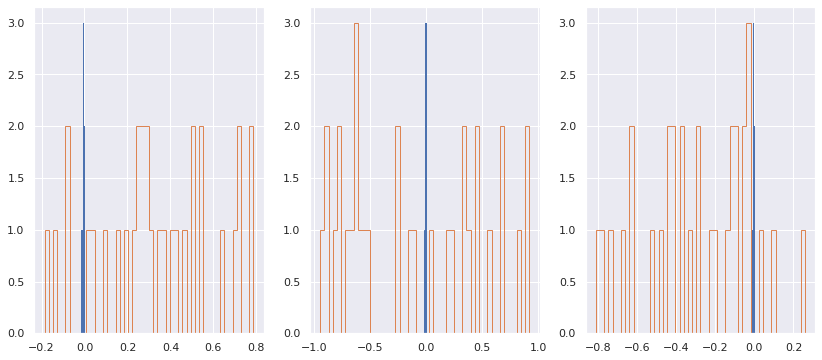

Train loss: 0.6755798293283102 - Train accuracy: 0.3909946084022522 - Loss change -0.023% | Validation accuracy 0.3908837139606476 | Epoch: 1


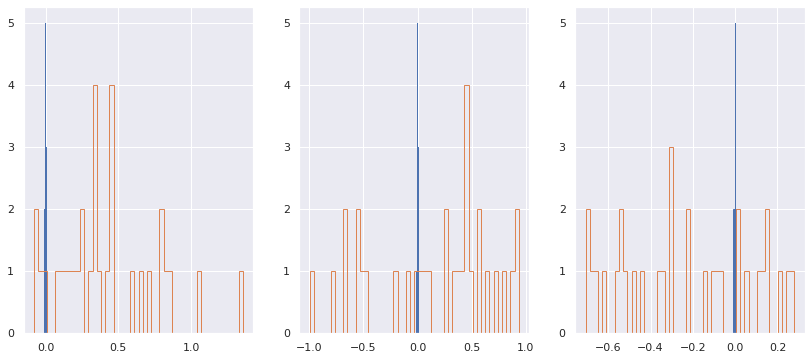

Train loss: 0.6755414113355318 - Train accuracy: 0.3909718692302704 - Loss change -0.006% | Validation accuracy 0.3905327022075653 | Epoch: 2


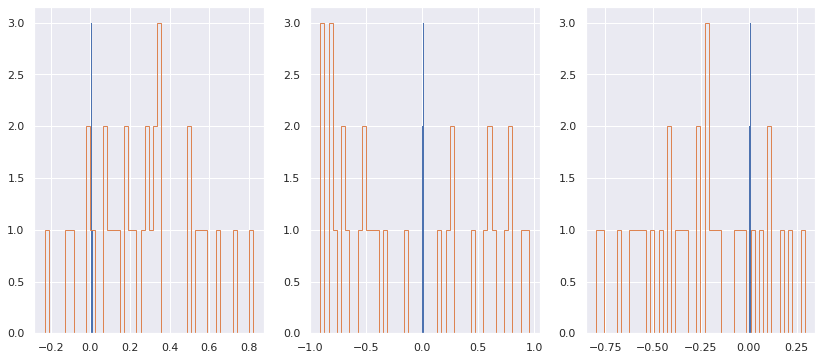

Train loss: 0.6754894052338788 - Train accuracy: 0.390969455242157 - Loss change -0.008% | Validation accuracy 0.39036011695861816 | Epoch: 3


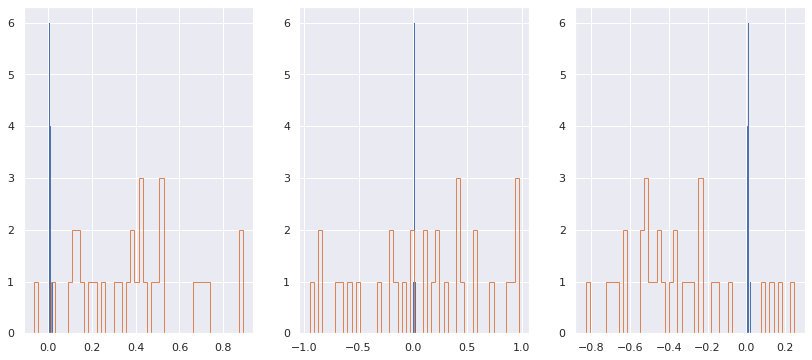

Train loss: 0.6754903933304083 - Train accuracy: 0.3909892439842224 - Loss change +0.000% | Validation accuracy 0.3902064561843872 | Epoch: 4


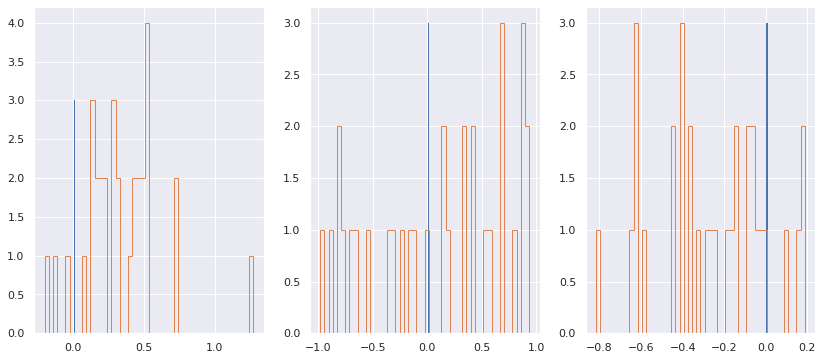

Train loss: 0.6754793173146205 - Train accuracy: 0.3909907341003418 - Loss change -0.002% | Validation accuracy 0.3903941810131073 | Epoch: 5


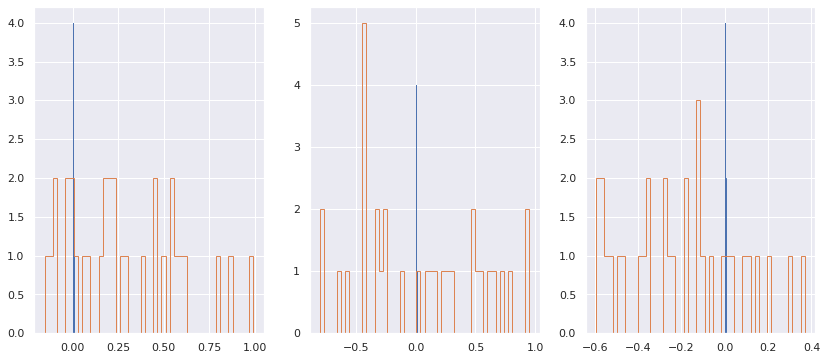

Train loss: 0.6754505037197993 - Train accuracy: 0.3909754455089569 - Loss change -0.004% | Validation accuracy 0.3904832601547241 | Epoch: 6


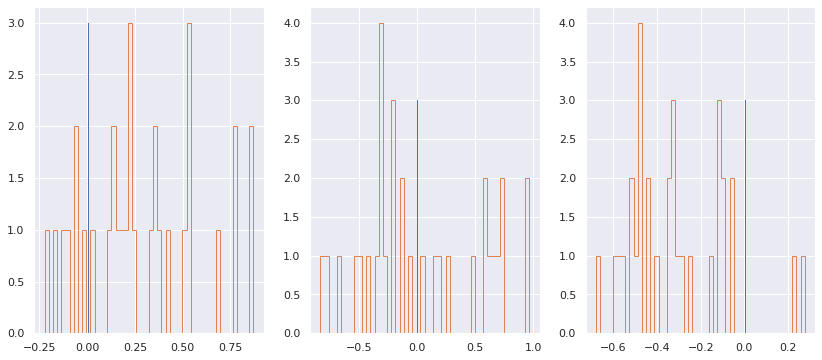

Train loss: 0.6754244872409201 - Train accuracy: 0.3909785747528076 - Loss change -0.004% | Validation accuracy 0.39038553833961487 | Epoch: 7


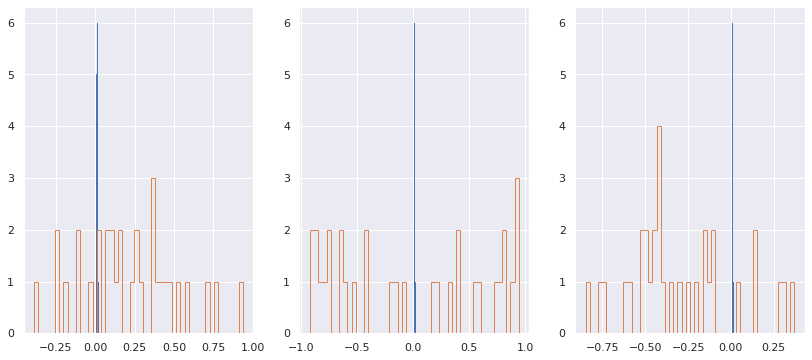

Train loss: 0.6754580500927357 - Train accuracy: 0.39100298285484314 - Loss change +0.005% | Validation accuracy 0.39033037424087524 | Epoch: 8


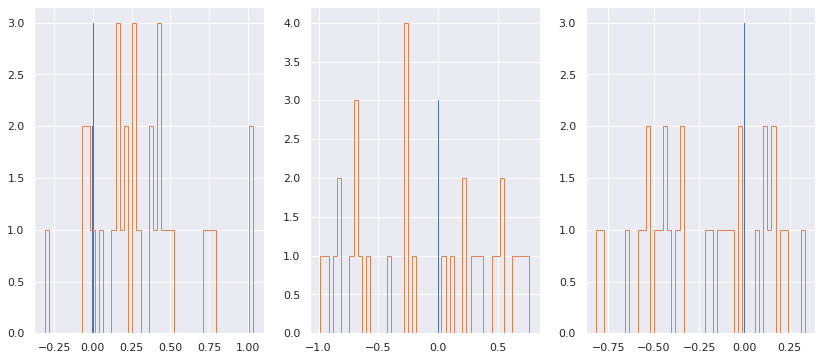

Train loss: 0.6754353837561612 - Train accuracy: 0.3910118341445923 - Loss change -0.003% | Validation accuracy 0.39069995284080505 | Epoch: 9


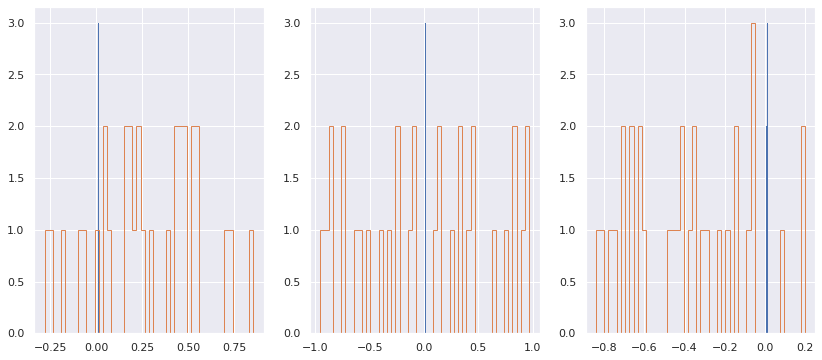

Train loss: 0.6754568664074502 - Train accuracy: 0.3910258114337921 - Loss change +0.003% | Validation accuracy 0.3903585374355316 | Epoch: 10


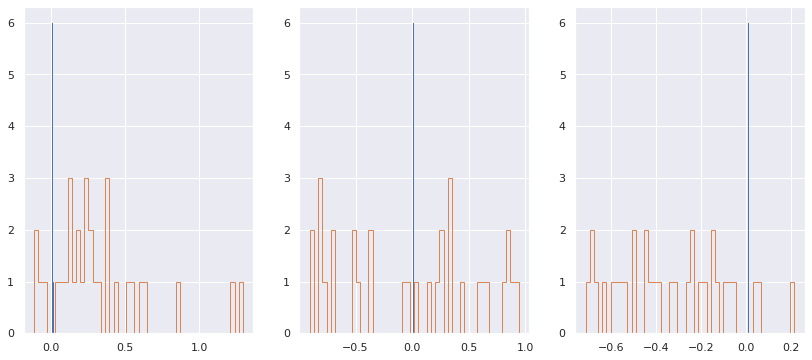

Train loss: 0.67544670932949 - Train accuracy: 0.3910239338874817 - Loss change -0.002% | Validation accuracy 0.3904324471950531 | Epoch: 11


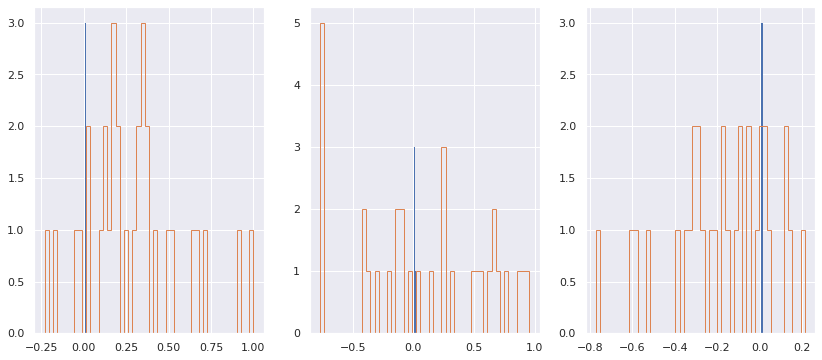

Train loss: 0.6754125737567127 - Train accuracy: 0.391011118888855 - Loss change -0.005% | Validation accuracy 0.390324205160141 | Epoch: 12


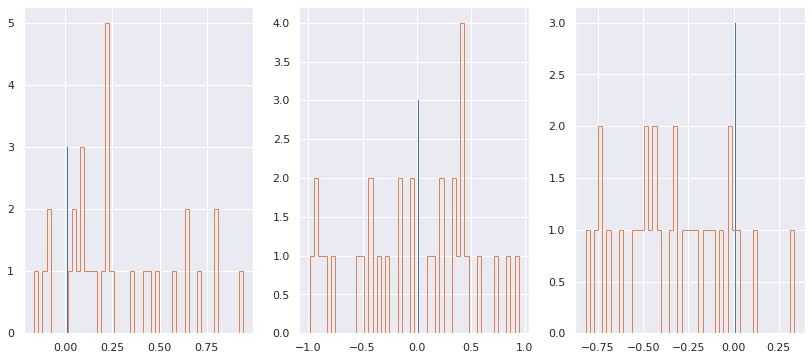

Train loss: 0.6754284482804683 - Train accuracy: 0.3910040557384491 - Loss change +0.002% | Validation accuracy 0.39032191038131714 | Epoch: 13


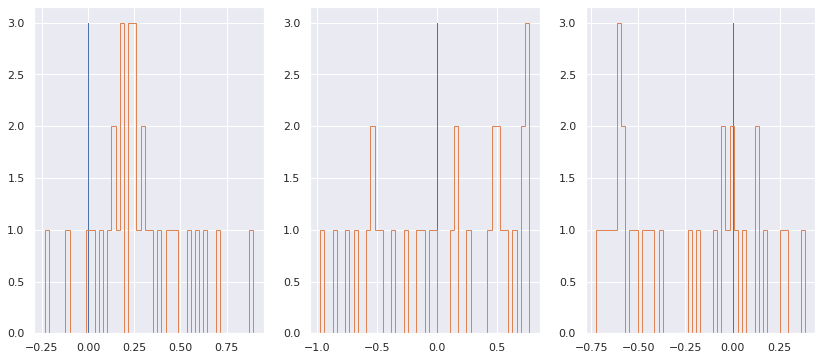

Train loss: 0.6754241450508461 - Train accuracy: 0.39101213216781616 - Loss change -0.001% | Validation accuracy 0.3905024230480194 | Epoch: 14


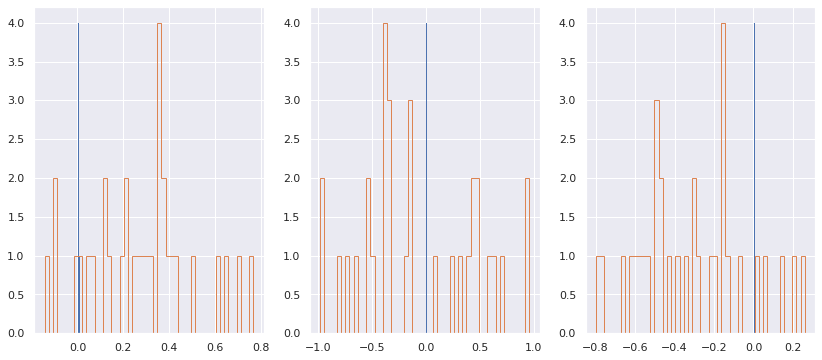

Train loss: 0.6754118220300704 - Train accuracy: 0.3910072147846222 - Loss change -0.002% | Validation accuracy 0.3903433084487915 | Epoch: 15


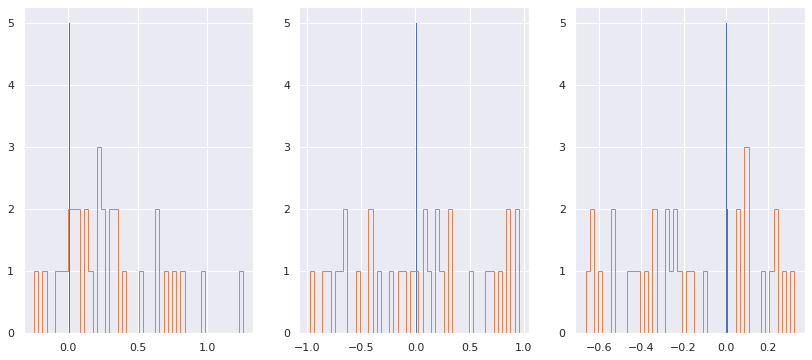

Train loss: 0.675425229657413 - Train accuracy: 0.39100033044815063 - Loss change +0.002% | Validation accuracy 0.39049214124679565 | Epoch: 16


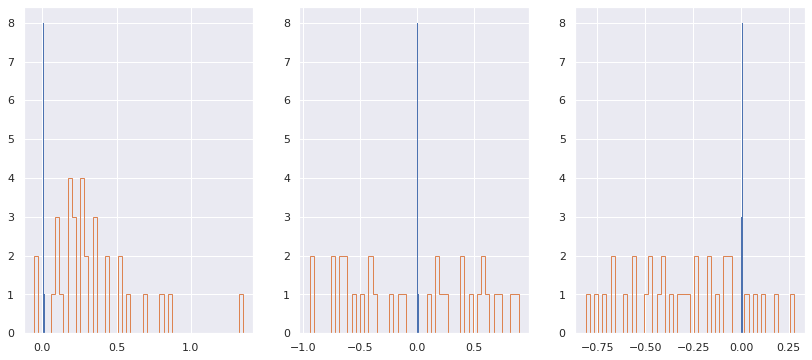

Train loss: 0.6754306856473111 - Train accuracy: 0.39100775122642517 - Loss change +0.001% | Validation accuracy 0.3904695212841034 | Epoch: 17


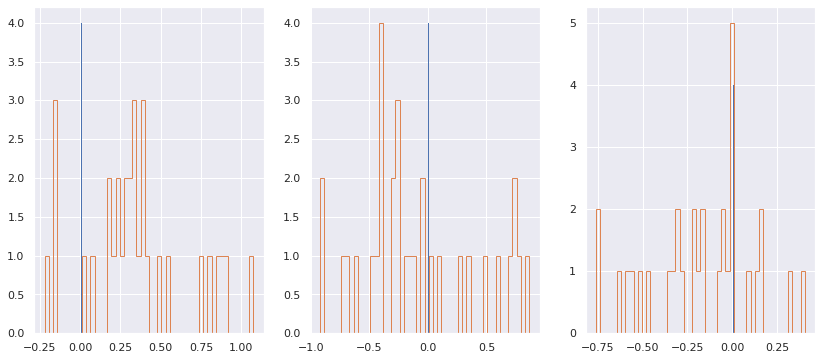

Train loss: 0.6754210922685608 - Train accuracy: 0.39099985361099243 - Loss change -0.001% | Validation accuracy 0.39040708541870117 | Epoch: 18


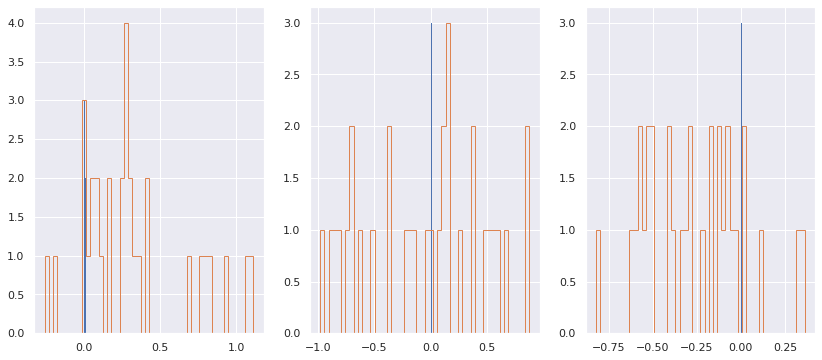

Train loss: 0.6754232033172084 - Train accuracy: 0.39099976420402527 - Loss change +0.000% | Validation accuracy 0.3904067575931549 | Epoch: 19


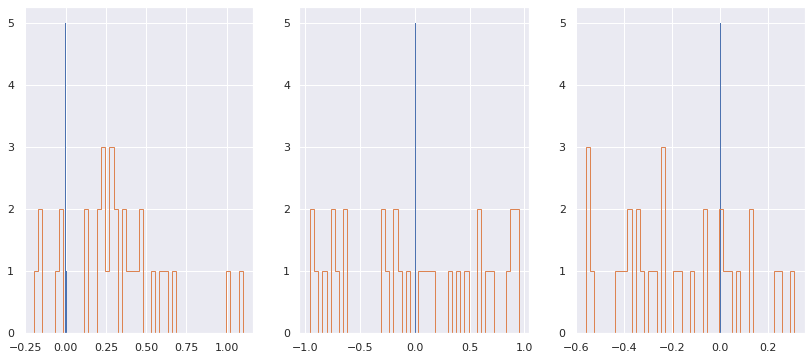

Train loss: 0.6754199125627611 - Train accuracy: 0.3909902572631836 - Loss change -0.000% | Validation accuracy 0.3905697166919708 | Epoch: 20


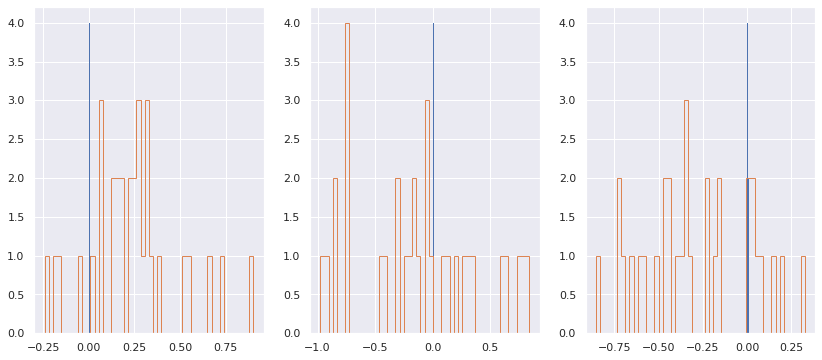

Train loss: 0.6754088028837033 - Train accuracy: 0.3909981846809387 - Loss change -0.002% | Validation accuracy 0.39047810435295105 | Epoch: 21


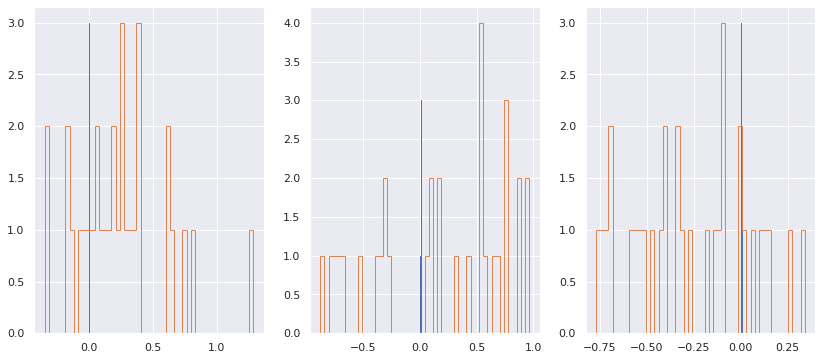

Train loss: 0.6754285124548509 - Train accuracy: 0.39100584387779236 - Loss change +0.003% | Validation accuracy 0.39035362005233765 | Epoch: 22


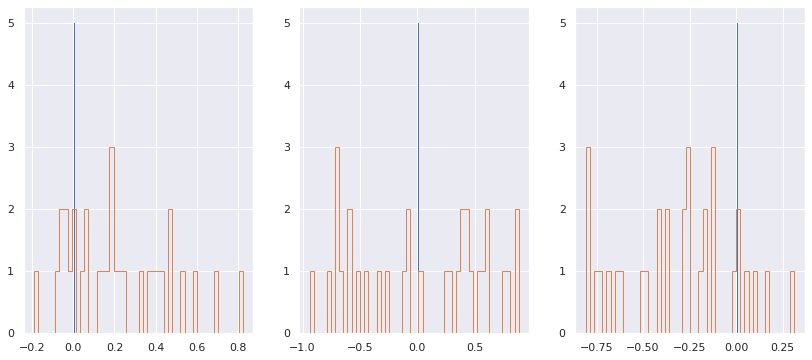

Train loss: 0.6754116355694265 - Train accuracy: 0.39098986983299255 - Loss change -0.002% | Validation accuracy 0.39036330580711365 | Epoch: 23


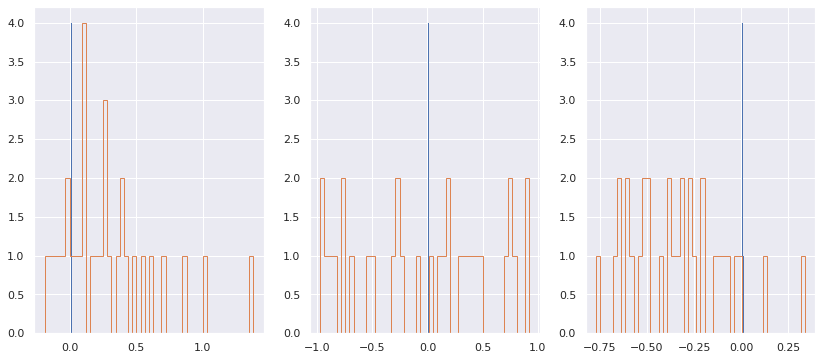

Train loss: 0.6754336611789792 - Train accuracy: 0.3910004496574402 - Loss change +0.003% | Validation accuracy 0.3903726041316986 | Epoch: 24


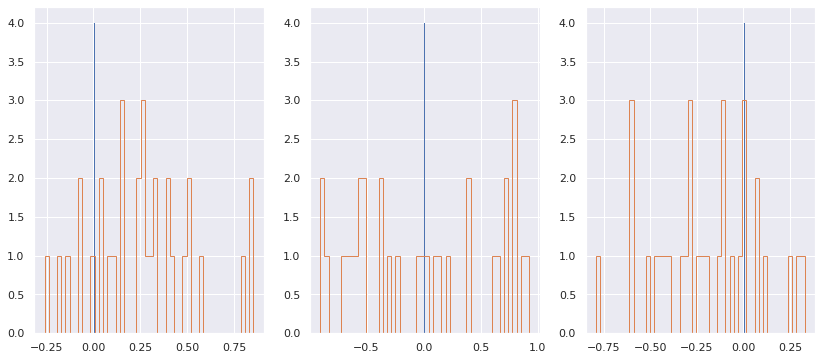

Train loss: 0.6754084417577993 - Train accuracy: 0.39099541306495667 - Loss change -0.004% | Validation accuracy 0.39047500491142273 | Epoch: 25


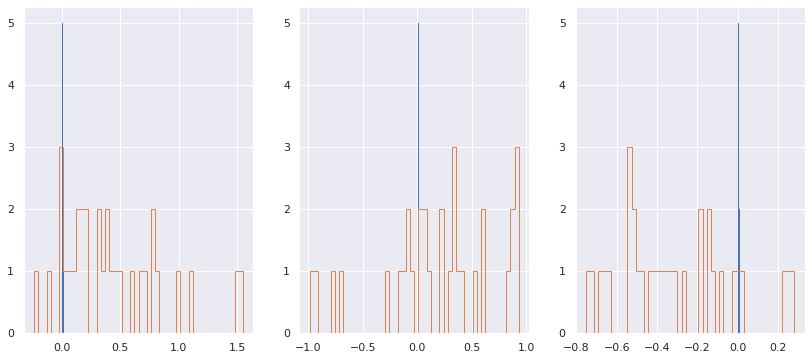

Train loss: 0.6754567489900144 - Train accuracy: 0.39101311564445496 - Loss change +0.007% | Validation accuracy 0.3904869854450226 | Epoch: 26


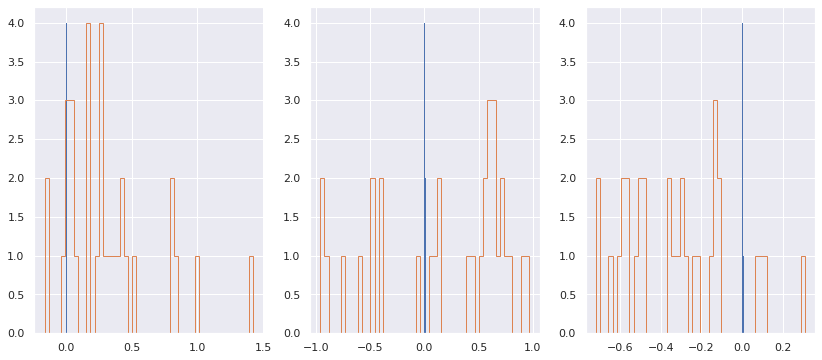

Train loss: 0.6754405586367535 - Train accuracy: 0.3910040855407715 - Loss change -0.002% | Validation accuracy 0.3904849588871002 | Epoch: 27


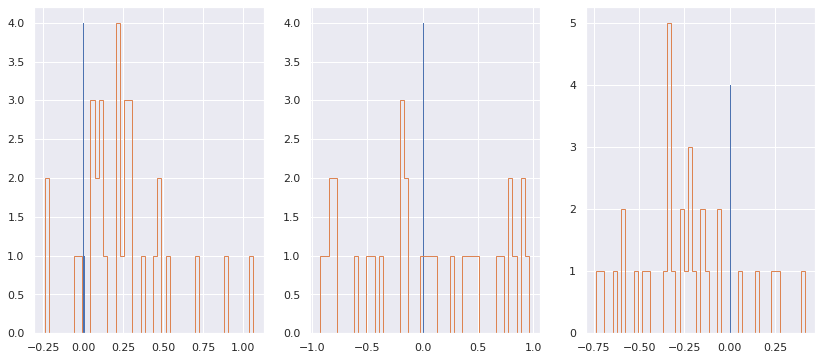

Train loss: 0.675420605562835 - Train accuracy: 0.39099523425102234 - Loss change -0.003% | Validation accuracy 0.3905150592327118 | Epoch: 28


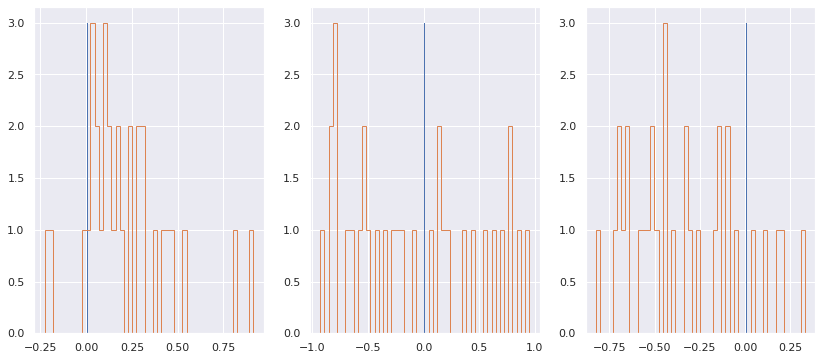

Train loss: 0.675415882316706 - Train accuracy: 0.39099347591400146 - Loss change -0.001% | Validation accuracy 0.39042770862579346 | Epoch: 29


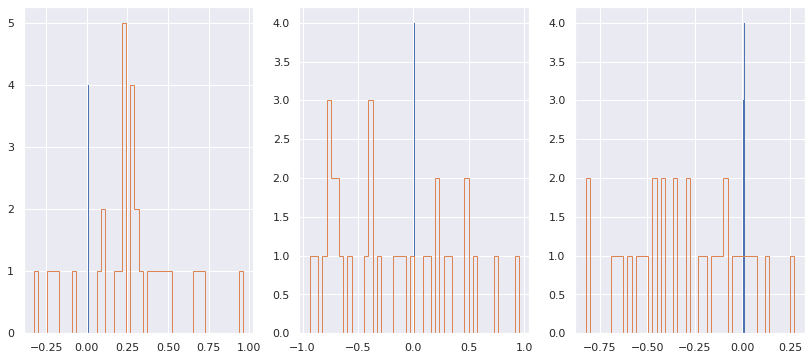

Train loss: 0.6754157937750941 - Train accuracy: 0.39099958539009094 - Loss change -0.000% | Validation accuracy 0.39041122794151306 | Epoch: 30


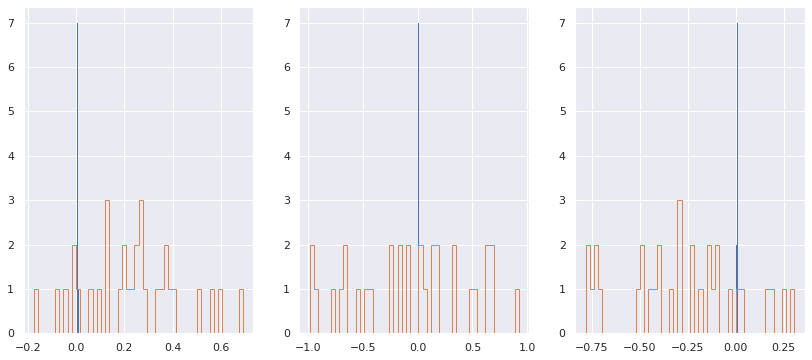

Train loss: 0.6753976048459392 - Train accuracy: 0.3909849226474762 - Loss change -0.003% | Validation accuracy 0.3904622793197632 | Epoch: 31


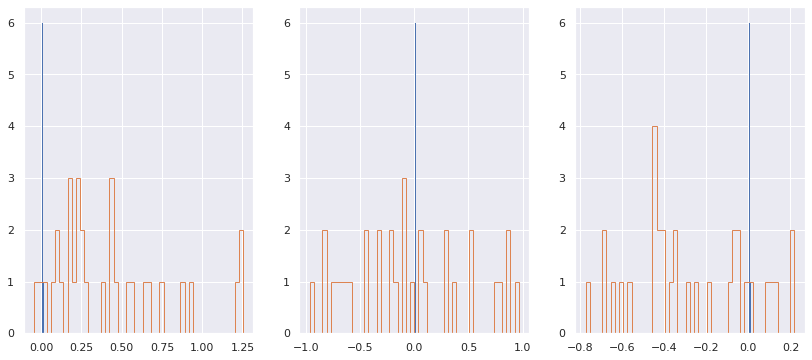

Train loss: 0.6754329767794155 - Train accuracy: 0.3910009264945984 - Loss change +0.005% | Validation accuracy 0.39042237401008606 | Epoch: 32


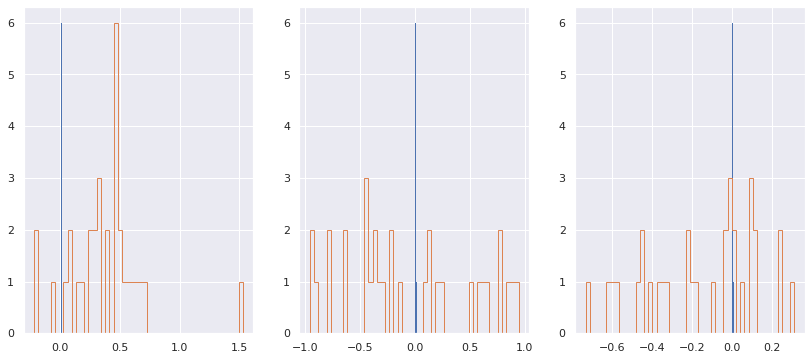

Train loss: 0.6754205785628083 - Train accuracy: 0.39098942279815674 - Loss change -0.002% | Validation accuracy 0.39044246077537537 | Epoch: 33


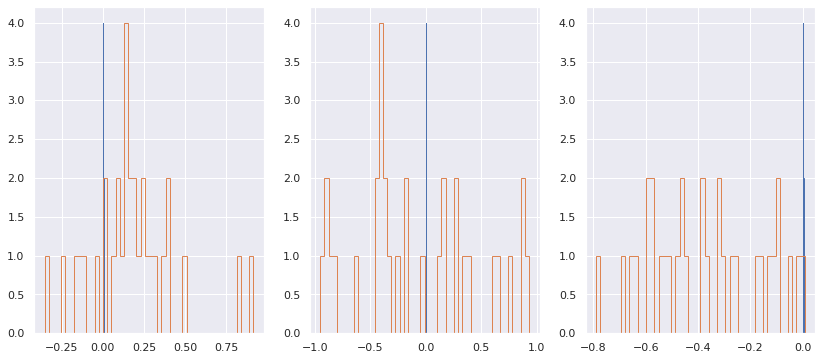

Train loss: 0.6754081922834438 - Train accuracy: 0.3909916877746582 - Loss change -0.002% | Validation accuracy 0.39045026898384094 | Epoch: 34


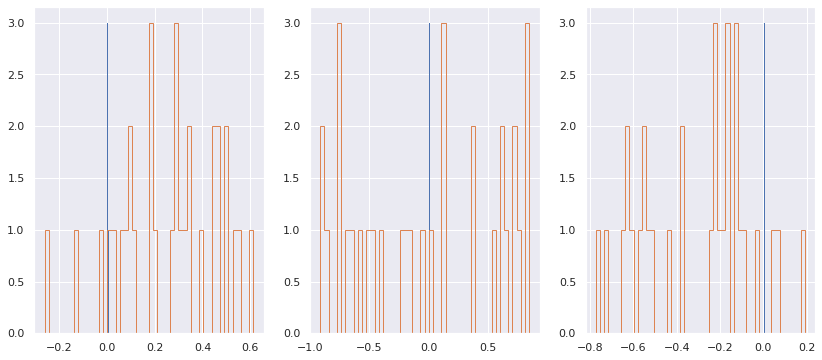

Train loss: 0.6754047505331598 - Train accuracy: 0.3909839987754822 - Loss change -0.001% | Validation accuracy 0.3904431164264679 | Epoch: 35


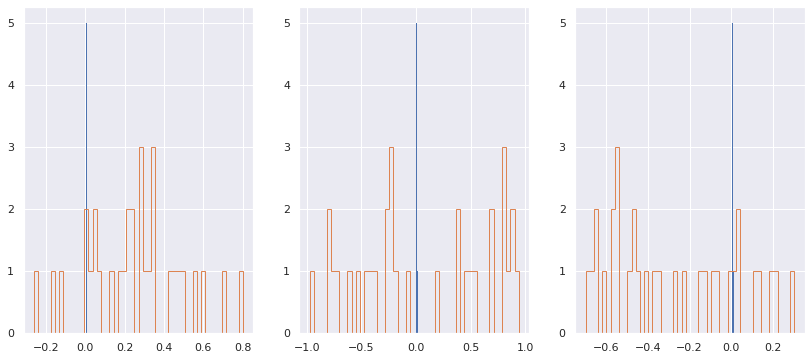

Train loss: 0.6754196084248711 - Train accuracy: 0.3909946382045746 - Loss change +0.002% | Validation accuracy 0.39046114683151245 | Epoch: 36


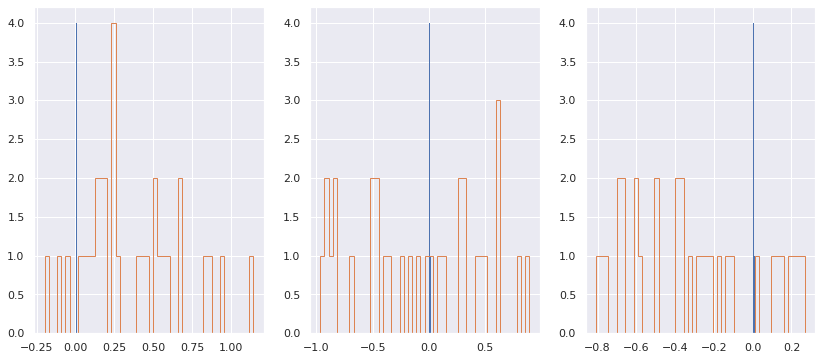

Train loss: 0.6754340802180281 - Train accuracy: 0.39099112153053284 - Loss change +0.002% | Validation accuracy 0.39043062925338745 | Epoch: 37


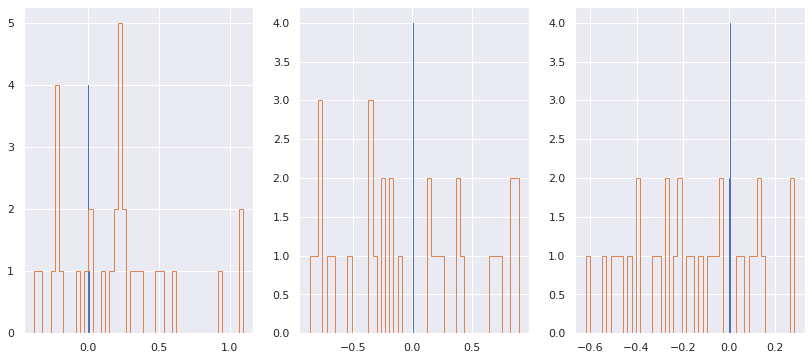

Train loss: 0.675399554718885 - Train accuracy: 0.3909771144390106 - Loss change -0.005% | Validation accuracy 0.39047133922576904 | Epoch: 38


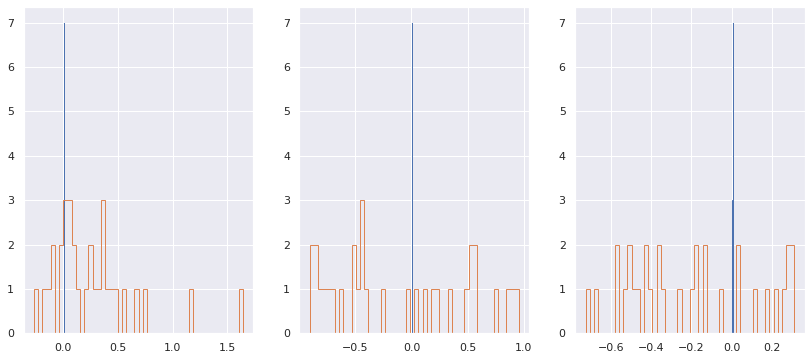

Train loss: 0.6754220988643487 - Train accuracy: 0.3909905254840851 - Loss change +0.003% | Validation accuracy 0.3903679847717285 | Epoch: 39


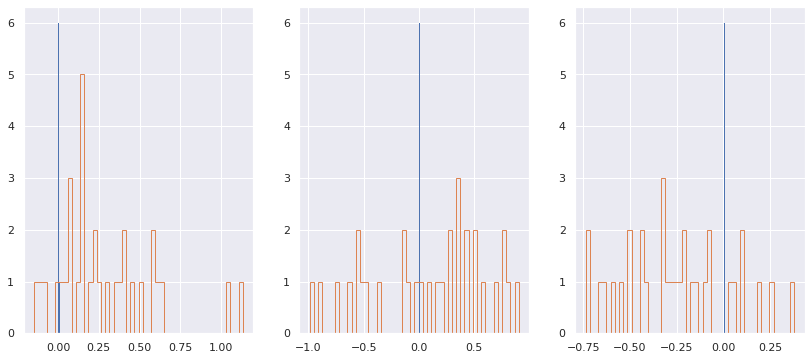

Train loss: 0.6754086448921826 - Train accuracy: 0.3909863829612732 - Loss change -0.002% | Validation accuracy 0.39044347405433655 | Epoch: 40


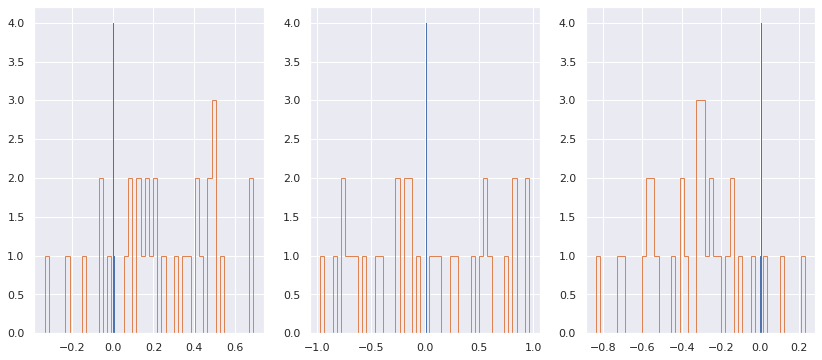

Train loss: 0.6754012088133127 - Train accuracy: 0.39098426699638367 - Loss change -0.001% | Validation accuracy 0.39043155312538147 | Epoch: 41


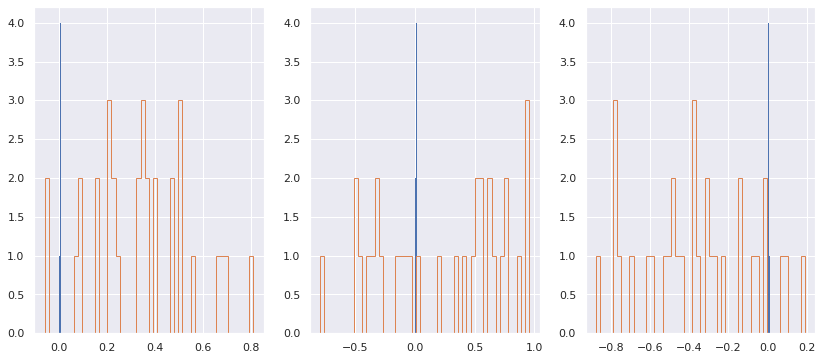

Train loss: 0.6754104382936804 - Train accuracy: 0.3909904658794403 - Loss change +0.001% | Validation accuracy 0.3904077708721161 | Epoch: 42


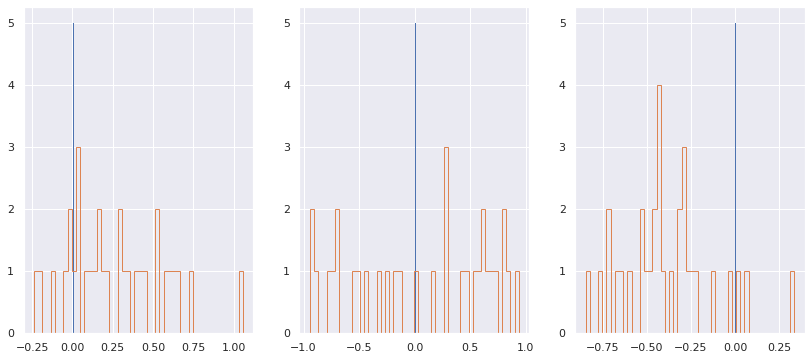

Train loss: 0.6754293648450145 - Train accuracy: 0.39099276065826416 - Loss change +0.003% | Validation accuracy 0.3904452323913574 | Epoch: 43


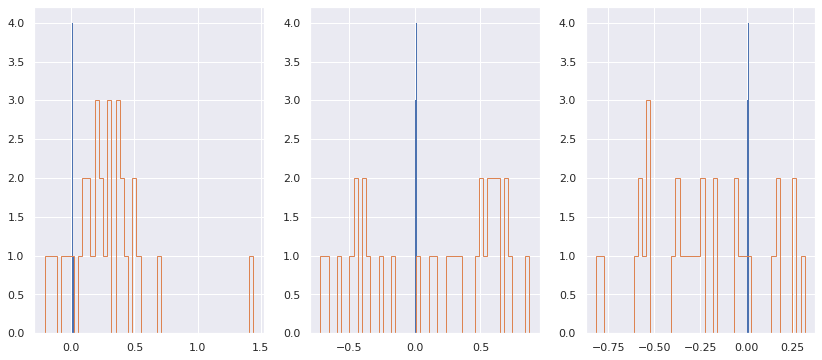

Train loss: 0.6753961364901822 - Train accuracy: 0.3909909129142761 - Loss change -0.005% | Validation accuracy 0.39035218954086304 | Epoch: 44


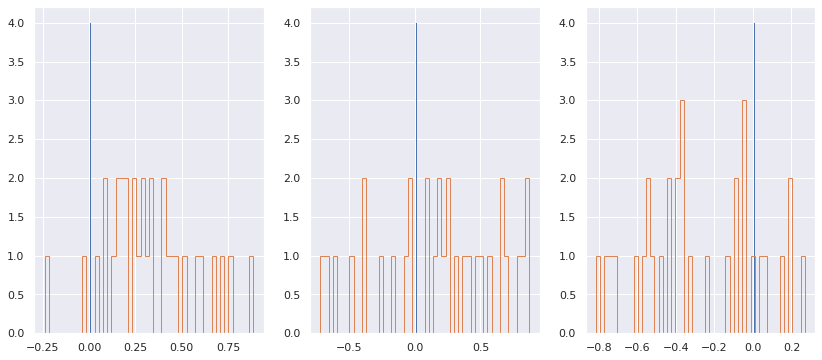

Train loss: 0.6753948674599113 - Train accuracy: 0.3909820020198822 - Loss change -0.000% | Validation accuracy 0.3903800845146179 | Epoch: 45


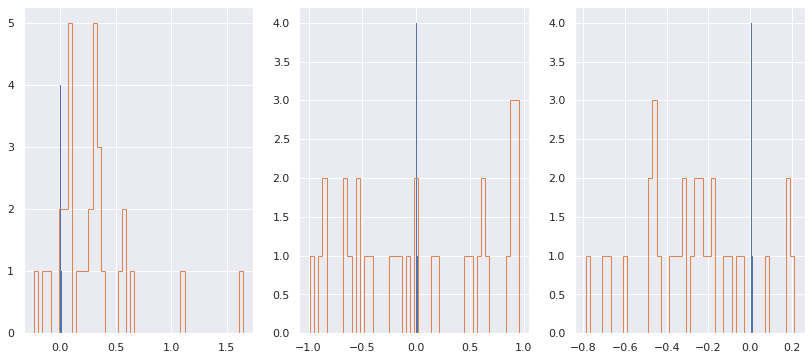

Train loss: 0.6754365892534221 - Train accuracy: 0.3909827470779419 - Loss change +0.006% | Validation accuracy 0.3904654085636139 | Epoch: 46


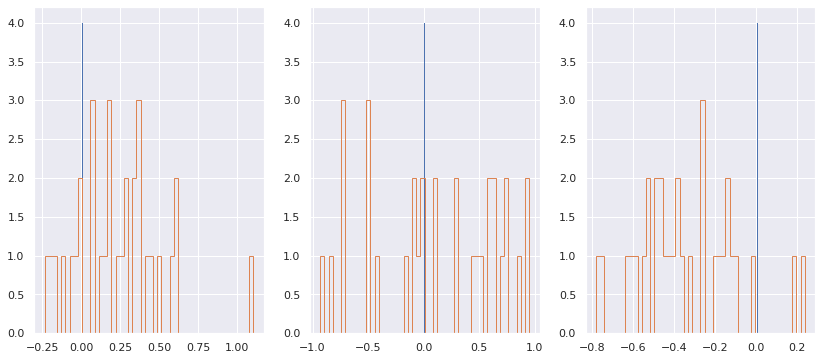

Train loss: 0.6754070190222026 - Train accuracy: 0.39098596572875977 - Loss change -0.004% | Validation accuracy 0.3904452919960022 | Epoch: 47


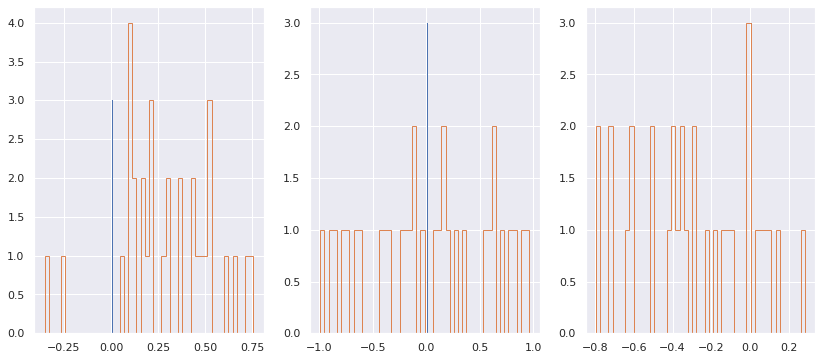

Train loss: 0.6754080186126227 - Train accuracy: 0.3909851014614105 - Loss change +0.000% | Validation accuracy 0.39038440585136414 | Epoch: 48


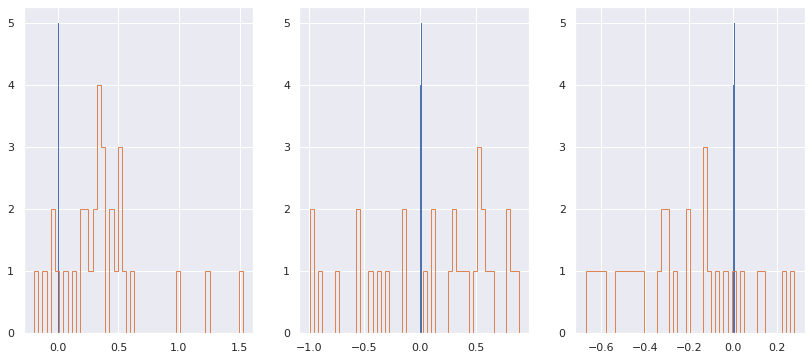

Train loss: 0.6754251719459549 - Train accuracy: 0.3909856677055359 - Loss change +0.003% | Validation accuracy 0.3904019594192505 | Epoch: 49


Training of the following model is now complete:
Model: "model_class_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


ValueError: ignored

In [ ]:
fit(train_loader)
print("\n\nTraining of the following model is now complete:")
model.summary()
save_path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/Saved Models"
pth = save_path + f"/{wandb.run.name}-{int(epochs)}epochs" 
# pth = save_path + "savetest"
# model.save(pth)